In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

import matplotlib.pyplot as plt

from torch.utils.data import random_split

In [2]:
import os
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Lambda
from torchvision.transforms import InterpolationMode

# Define la ruta a tu carpeta de base de datos
dataset_folder = 'C:/Users/Usuario/Desktop/data_aug7'

# Define la ruta a tu archivo CSV
csv_file_path = 'C:/Users/Usuario/Desktop/BDD7.csv'

batch_size = 128
emotion_dict = {'Felicidad':0, 'Diversión':0, 'Indiferencia':1, 'Curiosidad':0, 'Tristeza':2, 'Miedo':2, 'Desagrado':2}


#https://pytorch.org/hub/pytorch_vision_resnet/
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_m.html#torchvision.models.efficientnet_v2_m
# transform = T.Compose([
#     T.Resize(480, interpolation=InterpolationMode.BILINEAR),
#     T.CenterCrop(480),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


class CustomDataset(Dataset):
    def __init__(self, dataset_folder, csv_file_path, transform=None):
        self.dataset_folder = dataset_folder
        self.transform = transform

        # Lee el archivo CSV
        self.df = pd.read_csv(csv_file_path, sep=';')

        # Crea un diccionario para mapear nombres de imágenes a etiquetas
        self.label_dict = {row['nombre_imagen'].replace('\ufeff', '').strip(): row['label'].replace('\ufeff', '').strip() for _, row in self.df.iterrows()}

        # Obtiene una lista de nombres de archivos de imágenes
        self.image_filenames = sorted(os.listdir(dataset_folder))

        self.labels = [self.label_dict[filename] for filename in self.image_filenames]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.dataset_folder, image_filename)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        emotion_label = self.label_dict.get(image_filename).replace('\ufeff', '').strip()
        
        if emotion_label is None:
            print(f"La imagen {image_filename} no tiene una etiqueta correspondiente en el archivo CSV.")
            label = -1
        else:
            label = emotion_dict[emotion_label]

        return image, label

custom_dataset = CustomDataset(dataset_folder, csv_file_path, transform=transform)

# Divide los índices en índices de entrenamiento, validación y prueba
train_indices, test_indices = train_test_split(list(range(len(custom_dataset))), test_size=0.4, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42)

# Crea conjuntos de datos de entrenamiento, validación y prueba usando los índices divididos
train_dataset = Subset(custom_dataset, train_indices)
val_dataset = Subset(custom_dataset, val_indices)
test_dataset = Subset(custom_dataset, test_indices)

# Crea DataLoaders para tus conjuntos de datos
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Número de muestras en el conjunto de entrenamiento: {len(train_dataset)}")
print(f"Número de muestras en el conjunto de validación: {len(val_dataset)}")
print(f"Número de muestras en el conjunto de prueba: {len(test_dataset)}")


Número de muestras en el conjunto de entrenamiento: 8400
Número de muestras en el conjunto de validación: 2800
Número de muestras en el conjunto de prueba: 2800


In [3]:
for i, (x, y) in enumerate(train_loader):
    try:
        print(i, x.shape, y.shape)
    except Exception as e:
        print(f"Error en el lote {i}: {e}")


0 torch.Size([128, 3, 224, 224]) torch.Size([128])
1 torch.Size([128, 3, 224, 224]) torch.Size([128])
2 torch.Size([128, 3, 224, 224]) torch.Size([128])
3 torch.Size([128, 3, 224, 224]) torch.Size([128])
4 torch.Size([128, 3, 224, 224]) torch.Size([128])
5 torch.Size([128, 3, 224, 224]) torch.Size([128])
6 torch.Size([128, 3, 224, 224]) torch.Size([128])
7 torch.Size([128, 3, 224, 224]) torch.Size([128])
8 torch.Size([128, 3, 224, 224]) torch.Size([128])
9 torch.Size([128, 3, 224, 224]) torch.Size([128])
10 torch.Size([128, 3, 224, 224]) torch.Size([128])
11 torch.Size([128, 3, 224, 224]) torch.Size([128])
12 torch.Size([128, 3, 224, 224]) torch.Size([128])
13 torch.Size([128, 3, 224, 224]) torch.Size([128])
14 torch.Size([128, 3, 224, 224]) torch.Size([128])
15 torch.Size([128, 3, 224, 224]) torch.Size([128])
16 torch.Size([128, 3, 224, 224]) torch.Size([128])
17 torch.Size([128, 3, 224, 224]) torch.Size([128])
18 torch.Size([128, 3, 224, 224]) torch.Size([128])
19 torch.Size([128, 3,

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


1
11461.jpg


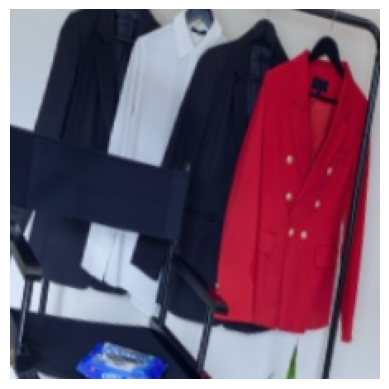

In [6]:
import numpy as np

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader.dataset))

# Obtiene el nombre del archivo de la imagen
image_filename = test_loader.dataset.dataset.image_filenames[rnd_sample_idx]

test_loader.dataset.dataset.labels = [label.strip() for label in test_loader.dataset.dataset.labels]

image, label = test_loader.dataset[rnd_sample_idx]
image = (image - image.min()) / (image.max() - image.min())

print(label)
print(image_filename)
plot_figure(image)


In [146]:
model_resnet152 = models.resnet152(pretrained=True)
model_efficientnet=models.efficientnet_v2_m(pretrained=True)

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Efficient

In [136]:
for i, w in enumerate(model_resnet152.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 1, 1]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([256, 64, 1, 1]) True
10 torch.Size([256]) True
11 torch.Size([256]) True
12 torch.Size([256, 64, 1, 1]) True
13 torch.Size([256]) True
14 torch.Size([256]) True
15 torch.Size([64, 256, 1, 1]) True
16 torch.Size([64]) True
17 torch.Size([64]) True
18 torch.Size([64, 64, 3, 3]) True
19 torch.Size([64]) True
20 torch.Size([64]) True
21 torch.Size([256, 64, 1, 1]) True
22 torch.Size([256]) True
23 torch.Size([256]) True
24 torch.Size([64, 256, 1, 1]) True
25 torch.Size([64]) True
26 torch.Size([64]) True
27 torch.Size([64, 64, 3, 3]) True
28 torch.Size([64]) True
29 torch.Size([64]) True
30 torch.Size([256, 64, 1, 1]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([128, 256, 1, 1]) True
34 torch.Size([128]) True

In [139]:
model_resnet152


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [148]:
model_aux_resnet152 = nn.Sequential(*list(model_resnet152.children()))
model_aux_efficientnet= nn.Sequential(*list(model_efficientnet.children()))
model_aux_efficientnet

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
           

In [149]:
model_aux_resnet152 = nn.Sequential(*list(model_resnet152.children())[:-1])
model_aux_efficientnet = nn.Sequential(*list(model_efficientnet.children())[:-1])

In [150]:
model_aux_efficientnet

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
           

In [155]:
for i, parameter in enumerate(model_aux_efficientnet.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False


In [105]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total 

In [106]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    train_accs = []
    val_accs = []
    criterion = torch.nn.NLLLoss()  
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            log_probs = F.log_softmax(scores, dim=1)  
            cost = criterion(log_probs, yi)  

            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        train_acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {val_acc},')

    return train_accs, val_accs


In [156]:
epochs = 45

model1 = nn.Sequential(model_aux_resnet152,
                        nn.Flatten(),
                        nn.Linear(in_features=2048, out_features= 3, bias= True))

model2 = nn.Sequential(model_aux_resnet152,
                        nn.Flatten(),
                        nn.Linear(in_features=2048, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 3, bias= True))

model3 = nn.Sequential(model_aux_resnet152,
                        nn.Flatten(),
                        nn.Linear(in_features=2048, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 3, bias= True))


model4 = nn.Sequential(model_aux_resnet152,
                        nn.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 128, bias= True), nn.ReLU(),
                        nn.Linear(in_features=128, out_features= 3, bias= True))

model5 = nn.Sequential(model_aux_resnet152,
                        nn.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 128, bias= True), nn.ReLU(),
                        nn.Linear(in_features=128, out_features= 3, bias= True))

model6 = nn.Sequential(model_aux_resnet152,
                        nn.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 128, bias= True), nn.ReLU(),
                        nn.Linear(in_features=128, out_features= 3, bias= True))

model7 = nn.Sequential(model_aux_efficientnet,
                        nn.Flatten(),
                        nn.Linear(in_features=1280, out_features= 3, bias= True))

model8 = nn.Sequential(model_aux_efficientnet,
                        nn.Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 128, bias= True), nn.ReLU(),
                        nn.Linear(in_features=128, out_features= 3, bias= True))

# optimiser = torch.optim.SGD(model4.parameters(), lr=0.062120553962991695)

In [107]:
import optuna

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Crear los dataloaders con el batch_size sugerido
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Definir el modelo
    model = nn.Sequential(model_aux_efficientnet,
                        nn.Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(256),
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features= 256, bias= True), nn.ReLU(),
                        nn.Linear(in_features=256, out_features= 128, bias= True), nn.ReLU(),
                        nn.Linear(in_features=128, out_features= 3, bias= True))

    # Definir el optimizador
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Entrena el modelo con los dataloaders creados
    train_accs, val_accs = train(model, optimizer, epochs=10)

    return val_accs[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)




c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-04 10:04:49,397] A new study created in memory with name: no-name-09743f56-d8f1-4d47-8543-1937905414ae


Epoch: 0, costo: 0.8346995711326599, accuracy: 0.6639285714285714,
Epoch: 1, costo: 0.3491637706756592, accuracy: 0.655,
Epoch: 2, costo: 0.7513740658760071, accuracy: 0.6828571428571428,
Epoch: 3, costo: 1.1723824739456177, accuracy: 0.6603571428571429,
Epoch: 4, costo: 0.49689608812332153, accuracy: 0.6825,
Epoch: 5, costo: 0.6508027911186218, accuracy: 0.6785714285714286,
Epoch: 6, costo: 1.5092217922210693, accuracy: 0.7021428571428572,
Epoch: 7, costo: 3.242631196975708, accuracy: 0.6892857142857143,
Epoch: 8, costo: 0.2168615609407425, accuracy: 0.7003571428571429,


[I 2024-06-04 10:21:06,733] Trial 0 finished with value: 0.6757142857142857 and parameters: {'lr': 0.0185792025198687, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6757142857142857.


Epoch: 9, costo: 0.9952595233917236, accuracy: 0.6757142857142857,
Epoch: 0, costo: 0.7125245928764343, accuracy: 0.6792857142857143,
Epoch: 1, costo: 0.7372341752052307, accuracy: 0.6875,
Epoch: 2, costo: 0.7290285229682922, accuracy: 0.6889285714285714,
Epoch: 3, costo: 0.43006858229637146, accuracy: 0.6839285714285714,
Epoch: 4, costo: 0.49918249249458313, accuracy: 0.6896428571428571,
Epoch: 5, costo: 0.7055315971374512, accuracy: 0.6921428571428572,
Epoch: 6, costo: 0.7161298990249634, accuracy: 0.7057142857142857,
Epoch: 7, costo: 0.6068331599235535, accuracy: 0.7092857142857143,
Epoch: 8, costo: 0.6240453124046326, accuracy: 0.7139285714285715,


[I 2024-06-04 10:37:34,780] Trial 1 finished with value: 0.7025 and parameters: {'lr': 0.06599028077152481, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7025.


Epoch: 9, costo: 0.4374850392341614, accuracy: 0.7025,
Epoch: 0, costo: 0.9135135412216187, accuracy: 0.6385714285714286,
Epoch: 1, costo: 0.6419166922569275, accuracy: 0.6546428571428572,
Epoch: 2, costo: 0.9430959224700928, accuracy: 0.6635714285714286,
Epoch: 3, costo: 0.7762334942817688, accuracy: 0.6635714285714286,
Epoch: 4, costo: 0.5928381681442261, accuracy: 0.6707142857142857,
Epoch: 5, costo: 0.5876314043998718, accuracy: 0.6685714285714286,
Epoch: 6, costo: 0.5579499006271362, accuracy: 0.6746428571428571,
Epoch: 7, costo: 0.6511650085449219, accuracy: 0.6789285714285714,
Epoch: 8, costo: 0.5833764672279358, accuracy: 0.6775,


[I 2024-06-04 10:54:11,408] Trial 2 finished with value: 0.6753571428571429 and parameters: {'lr': 0.0001521514410850763, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.7025.


Epoch: 9, costo: 1.0423378944396973, accuracy: 0.6753571428571429,
Epoch: 0, costo: 1.128605842590332, accuracy: 0.6782142857142858,
Epoch: 1, costo: 0.6460053324699402, accuracy: 0.6732142857142858,
Epoch: 2, costo: 0.41816195845603943, accuracy: 0.6742857142857143,
Epoch: 3, costo: 0.48199889063835144, accuracy: 0.6839285714285714,
Epoch: 4, costo: 0.6082385182380676, accuracy: 0.6871428571428572,
Epoch: 5, costo: 0.8262457251548767, accuracy: 0.6892857142857143,
Epoch: 6, costo: 0.518358051776886, accuracy: 0.6942857142857143,
Epoch: 7, costo: 0.8263176679611206, accuracy: 0.6982142857142857,
Epoch: 8, costo: 0.6806418299674988, accuracy: 0.7032142857142857,


[I 2024-06-04 11:10:30,942] Trial 3 finished with value: 0.7010714285714286 and parameters: {'lr': 0.04043215087953181, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7025.


Epoch: 9, costo: 0.5135895013809204, accuracy: 0.7010714285714286,
Epoch: 0, costo: 0.9713794589042664, accuracy: 0.4525,
Epoch: 1, costo: 0.9471232891082764, accuracy: 0.5042857142857143,
Epoch: 2, costo: 0.905393123626709, accuracy: 0.5278571428571428,
Epoch: 3, costo: 0.8269453644752502, accuracy: 0.5532142857142858,
Epoch: 4, costo: 0.8980154991149902, accuracy: 0.5732142857142857,
Epoch: 5, costo: 0.8817225098609924, accuracy: 0.5910714285714286,
Epoch: 6, costo: 0.8366474509239197, accuracy: 0.6128571428571429,
Epoch: 7, costo: 0.8765383362770081, accuracy: 0.6246428571428572,
Epoch: 8, costo: 0.6349889636039734, accuracy: 0.6303571428571428,


[I 2024-06-04 11:26:46,584] Trial 4 finished with value: 0.6289285714285714 and parameters: {'lr': 1.0192280133034748e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7025.


Epoch: 9, costo: 0.7007991075515747, accuracy: 0.6289285714285714,
Epoch: 0, costo: 3.188832998275757, accuracy: 0.5807142857142857,
Epoch: 1, costo: 1.0488786697387695, accuracy: 0.6178571428571429,
Epoch: 2, costo: 2.152122974395752, accuracy: 0.5835714285714285,
Epoch: 3, costo: 1.6641851663589478, accuracy: 0.6725,
Epoch: 4, costo: 0.9087619185447693, accuracy: 0.6135714285714285,
Epoch: 5, costo: 2.245497226715088, accuracy: 0.6628571428571428,
Epoch: 6, costo: 2.543529748916626, accuracy: 0.6921428571428572,
Epoch: 7, costo: 0.5528464913368225, accuracy: 0.6871428571428572,
Epoch: 8, costo: 2.8445706367492676, accuracy: 0.6646428571428571,


[I 2024-06-04 11:43:04,475] Trial 5 finished with value: 0.6721428571428572 and parameters: {'lr': 0.08185338711109998, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.7025.


Epoch: 9, costo: 2.7506818771362305, accuracy: 0.6721428571428572,
Epoch: 0, costo: 0.8627285361289978, accuracy: 0.6682142857142858,
Epoch: 1, costo: 0.8386603593826294, accuracy: 0.6778571428571428,
Epoch: 2, costo: 0.7646639347076416, accuracy: 0.6867857142857143,
Epoch: 3, costo: 0.9910155534744263, accuracy: 0.6828571428571428,
Epoch: 4, costo: 0.5892912149429321, accuracy: 0.6885714285714286,
Epoch: 5, costo: 0.6943673491477966, accuracy: 0.6960714285714286,
Epoch: 6, costo: 0.6672372817993164, accuracy: 0.6964285714285714,
Epoch: 7, costo: 0.7655913829803467, accuracy: 0.6985714285714286,
Epoch: 8, costo: 0.5998098850250244, accuracy: 0.6989285714285715,


[I 2024-06-04 11:59:29,519] Trial 6 finished with value: 0.7085714285714285 and parameters: {'lr': 0.0006034308701694403, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7085714285714285.


Epoch: 9, costo: 0.6293277740478516, accuracy: 0.7085714285714285,
Epoch: 0, costo: 0.9015951156616211, accuracy: 0.6678571428571428,
Epoch: 1, costo: 0.5561600923538208, accuracy: 0.6775,
Epoch: 2, costo: 0.593228280544281, accuracy: 0.68,
Epoch: 3, costo: 0.5868588089942932, accuracy: 0.6796428571428571,
Epoch: 4, costo: 0.5735224485397339, accuracy: 0.6921428571428572,
Epoch: 5, costo: 0.7014716863632202, accuracy: 0.6928571428571428,
Epoch: 6, costo: 0.5076163411140442, accuracy: 0.6992857142857143,
Epoch: 7, costo: 0.6660147309303284, accuracy: 0.7032142857142857,
Epoch: 8, costo: 0.4641292691230774, accuracy: 0.7035714285714286,


[I 2024-06-04 12:16:10,643] Trial 7 finished with value: 0.7107142857142857 and parameters: {'lr': 0.0006555864661727821, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.7107142857142857.


Epoch: 9, costo: 0.5976149439811707, accuracy: 0.7107142857142857,
Epoch: 0, costo: 0.9013463258743286, accuracy: 0.6528571428571428,
Epoch: 1, costo: 2.3756141662597656, accuracy: 0.6196428571428572,
Epoch: 2, costo: 0.5976153016090393, accuracy: 0.6553571428571429,
Epoch: 3, costo: 4.09953498840332, accuracy: 0.645,
Epoch: 4, costo: 1.9279266595840454, accuracy: 0.6171428571428571,
Epoch: 5, costo: 0.7241586446762085, accuracy: 0.6882142857142857,
Epoch: 6, costo: 0.361350417137146, accuracy: 0.7110714285714286,
Epoch: 7, costo: 1.0359481573104858, accuracy: 0.6910714285714286,
Epoch: 8, costo: 0.7979304790496826, accuracy: 0.6639285714285714,


[I 2024-06-04 12:33:08,569] Trial 8 finished with value: 0.6989285714285715 and parameters: {'lr': 0.011291445171893072, 'batch_size': 256, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.7107142857142857.


Epoch: 9, costo: 0.4469462037086487, accuracy: 0.6989285714285715,
Epoch: 0, costo: 1.639559030532837, accuracy: 0.6285714285714286,
Epoch: 1, costo: 1.466447353363037, accuracy: 0.5975,
Epoch: 2, costo: 1.177147388458252, accuracy: 0.6610714285714285,
Epoch: 3, costo: 2.557954788208008, accuracy: 0.625,
Epoch: 4, costo: 1.841403603553772, accuracy: 0.6360714285714286,
Epoch: 5, costo: 1.0594955682754517, accuracy: 0.675,
Epoch: 6, costo: 1.2362229824066162, accuracy: 0.6360714285714286,
Epoch: 7, costo: 1.2259714603424072, accuracy: 0.6310714285714286,
Epoch: 8, costo: 1.947927713394165, accuracy: 0.6507142857142857,


[I 2024-06-04 12:49:26,504] Trial 9 finished with value: 0.6310714285714286 and parameters: {'lr': 0.028098514843183466, 'batch_size': 64, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.7107142857142857.


Epoch: 9, costo: 2.875795364379883, accuracy: 0.6310714285714286,
Epoch: 0, costo: 0.8868494629859924, accuracy: 0.6685714285714286,
Epoch: 1, costo: 0.6679128408432007, accuracy: 0.6885714285714286,
Epoch: 2, costo: 0.5891749858856201, accuracy: 0.6935714285714286,
Epoch: 3, costo: 0.3746243417263031, accuracy: 0.7085714285714285,
Epoch: 4, costo: 0.7089208960533142, accuracy: 0.7046428571428571,
Epoch: 5, costo: 0.6023839712142944, accuracy: 0.7082142857142857,
Epoch: 6, costo: 0.667557954788208, accuracy: 0.7153571428571428,
Epoch: 7, costo: 0.7721548080444336, accuracy: 0.7167857142857142,
Epoch: 8, costo: 0.8313677310943604, accuracy: 0.7175,


[I 2024-06-04 13:06:03,595] Trial 10 finished with value: 0.7128571428571429 and parameters: {'lr': 0.002117657979593861, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.7128571428571429.


Epoch: 9, costo: 0.5556073784828186, accuracy: 0.7128571428571429,
Epoch: 0, costo: 0.8473532199859619, accuracy: 0.6732142857142858,
Epoch: 1, costo: 0.6684809923171997, accuracy: 0.6885714285714286,
Epoch: 2, costo: 0.5194647908210754, accuracy: 0.6964285714285714,
Epoch: 3, costo: 0.4959923028945923, accuracy: 0.7075,
Epoch: 4, costo: 0.5985825657844543, accuracy: 0.7092857142857143,
Epoch: 5, costo: 0.8058581352233887, accuracy: 0.7085714285714285,
Epoch: 6, costo: 1.0161489248275757, accuracy: 0.7096428571428571,
Epoch: 7, costo: 0.4999553859233856, accuracy: 0.7225,
Epoch: 8, costo: 0.8516755700111389, accuracy: 0.7203571428571428,


[I 2024-06-04 13:23:10,435] Trial 11 finished with value: 0.7228571428571429 and parameters: {'lr': 0.0021849259017223143, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.7228571428571429.


Epoch: 9, costo: 0.8287859559059143, accuracy: 0.7228571428571429,
Epoch: 0, costo: 0.914523720741272, accuracy: 0.6821428571428572,
Epoch: 1, costo: 0.7056031823158264, accuracy: 0.6914285714285714,
Epoch: 2, costo: 0.6850258111953735, accuracy: 0.6967857142857142,
Epoch: 3, costo: 0.4730222821235657, accuracy: 0.7064285714285714,
Epoch: 4, costo: 0.941534161567688, accuracy: 0.7139285714285715,
Epoch: 5, costo: 0.6525941491127014, accuracy: 0.715,
Epoch: 6, costo: 0.5990622043609619, accuracy: 0.72,
Epoch: 7, costo: 0.6216300129890442, accuracy: 0.7078571428571429,
Epoch: 8, costo: 0.5053567886352539, accuracy: 0.7142857142857143,


[I 2024-06-04 13:39:28,332] Trial 12 finished with value: 0.7253571428571428 and parameters: {'lr': 0.003532938190694253, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.7253571428571428.


Epoch: 9, costo: 0.7090258598327637, accuracy: 0.7253571428571428,
Epoch: 0, costo: 0.8763211965560913, accuracy: 0.6821428571428572,
Epoch: 1, costo: 0.4049120545387268, accuracy: 0.6939285714285715,
Epoch: 2, costo: 0.6336010694503784, accuracy: 0.7075,
Epoch: 3, costo: 0.6405097246170044, accuracy: 0.7071428571428572,
Epoch: 4, costo: 0.754302442073822, accuracy: 0.7064285714285714,
Epoch: 5, costo: 0.6687851548194885, accuracy: 0.7142857142857143,
Epoch: 6, costo: 0.7203162312507629, accuracy: 0.7153571428571428,
Epoch: 7, costo: 0.4598985016345978, accuracy: 0.7125,
Epoch: 8, costo: 0.3825643062591553, accuracy: 0.7317857142857143,


[I 2024-06-04 13:55:35,464] Trial 13 finished with value: 0.7207142857142858 and parameters: {'lr': 0.003279818676819931, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.7253571428571428.


Epoch: 9, costo: 0.4172583520412445, accuracy: 0.7207142857142858,
Epoch: 0, costo: 1.001357078552246, accuracy: 0.3796428571428571,
Epoch: 1, costo: 0.9764344096183777, accuracy: 0.4517857142857143,
Epoch: 2, costo: 1.0336905717849731, accuracy: 0.4789285714285714,
Epoch: 3, costo: 0.9651521444320679, accuracy: 0.4982142857142857,
Epoch: 4, costo: 1.0610404014587402, accuracy: 0.5307142857142857,
Epoch: 5, costo: 0.9519854187965393, accuracy: 0.5485714285714286,
Epoch: 6, costo: 0.866891622543335, accuracy: 0.5635714285714286,
Epoch: 7, costo: 0.9113297462463379, accuracy: 0.5635714285714286,
Epoch: 8, costo: 0.8316048383712769, accuracy: 0.5803571428571429,


[I 2024-06-04 14:11:42,193] Trial 14 finished with value: 0.5832142857142857 and parameters: {'lr': 0.00015966337741706062, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 12 with value: 0.7253571428571428.


Epoch: 9, costo: 0.9063030481338501, accuracy: 0.5832142857142857,


In [157]:
# Definir los hiperparámetros y optimizadores para cada modelo
configuraciones = [
    {'lr': 0.08022489092966884, 'optimizador': torch.optim.Adam, 'batch_size': 128, 'optim_args': {'betas': (0.9, 0.999)}},
    {'lr': 0.01003175886758875, 'optimizador': torch.optim.Adam, 'batch_size': 128, 'optim_args': {'betas': (0.9, 0.999)}},
    {'lr': 0.0018581185349004162, 'optimizador': torch.optim.Adam, 'batch_size': 32, 'optim_args': {'betas': (0.9, 0.999)}},
    {'lr': 0.062120553962991695, 'optimizador': torch.optim.SGD, 'batch_size': 32, 'optim_args': {}},
    {'lr': 0.00020078402705114983, 'optimizador': torch.optim.Adam, 'batch_size': 32, 'optim_args': {'betas': (0.9, 0.999)}},
    {'lr': 0.0002840606782513624, 'optimizador': torch.optim.RMSprop, 'batch_size': 64, 'optim_args': {}},
    {'lr': 0.003532938190694253, 'optimizador': torch.optim.Adam, 'batch_size': 16, 'optim_args': {'betas': (0.9, 0.999)}},
    {'lr': 0.000294296317510532, 'optimizador': torch.optim.Adam, 'batch_size': 128, 'optim_args': {'betas': (0.9, 0.999)}}
]


modelos = [model1, model2, model3, model4, model5, model6, model7, model8]
resultados = {}

for i, (modelo, config) in enumerate(zip(modelos, configuraciones)):
    
    print(f'Entrenando el modelo {i+1} con lr={config["lr"]}, batch_size={config["batch_size"]} y optimizador={config["optimizador"].__name__}')
    
    # Crear los dataloaders con el batch_size correspondiente
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    # Crear el optimizador con el lr correspondiente
    if config['optimizador'] == torch.optim.Adam:
        optimizador = config['optimizador'](modelo.parameters(), lr=config['lr'], betas=config['optim_args'].get('betas', (0.9, 0.999)))
    else:
        optimizador = config['optimizador'](modelo.parameters(), lr=config['lr'])
    
    train_accs, val_accs = train(modelo, optimizador, epochs)
    
    test_acc = accuracy(modelo, test_loader)
    
    # Guardar los resultados
    resultados[f'modelo_{i+8}'] = {
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_acc': test_acc
    }

Entrenando el modelo 8 con lr=0.000294296317510532, batch_size=128 y optimizador=Adam
Epoch: 0, costo: 0.6713020205497742, accuracy: 0.6896428571428571,
Epoch: 1, costo: 0.5631718039512634, accuracy: 0.7371428571428571,
Epoch: 2, costo: 0.479867160320282, accuracy: 0.7857142857142857,
Epoch: 3, costo: 0.27399325370788574, accuracy: 0.8282142857142857,
Epoch: 4, costo: 0.381761759519577, accuracy: 0.8457142857142858,
Epoch: 5, costo: 0.34096837043762207, accuracy: 0.87,
Epoch: 6, costo: 0.19193115830421448, accuracy: 0.8882142857142857,
Epoch: 7, costo: 0.2726917862892151, accuracy: 0.8860714285714286,
Epoch: 8, costo: 0.39389294385910034, accuracy: 0.9042857142857142,
Epoch: 9, costo: 0.0906025618314743, accuracy: 0.9060714285714285,
Epoch: 10, costo: 0.3245238661766052, accuracy: 0.9125,
Epoch: 11, costo: 0.17672453820705414, accuracy: 0.9182142857142858,
Epoch: 12, costo: 0.11183043569326401, accuracy: 0.9228571428571428,
Epoch: 13, costo: 0.21071942150592804, accuracy: 0.92785714285

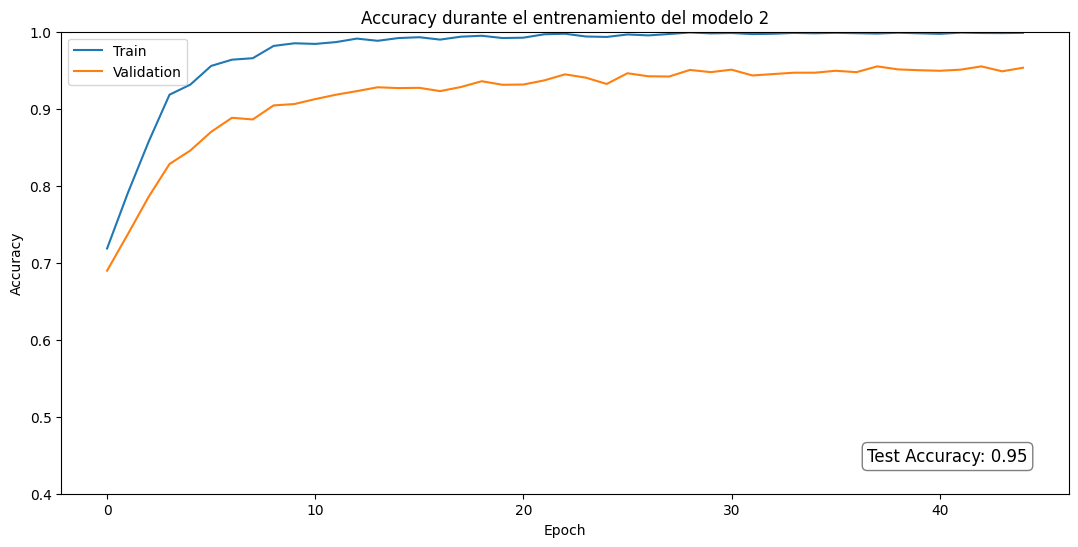

In [158]:
# Acceder a los datos del primer modelo
train_accs_model1 = resultados['modelo_8']['train_accs']
val_accs_model1 = resultados['modelo_8']['val_accs']
test_acc_model1 = resultados['modelo_8']['test_acc']

plt.figure(figsize=(13, 6))

plt.plot(train_accs_model1, label='Train')
plt.plot(val_accs_model1, label='Validation')

# Configurar el título y las etiquetas
plt.title('Accuracy durante el entrenamiento del modelo 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.ylim(0.4, 1)

# Agregar el accuracy de prueba en un recuadro
plt.text(0.8, 0.1, f'Test Accuracy: {test_acc_model1:.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


Generando matriz de confusión para el modelo 1...


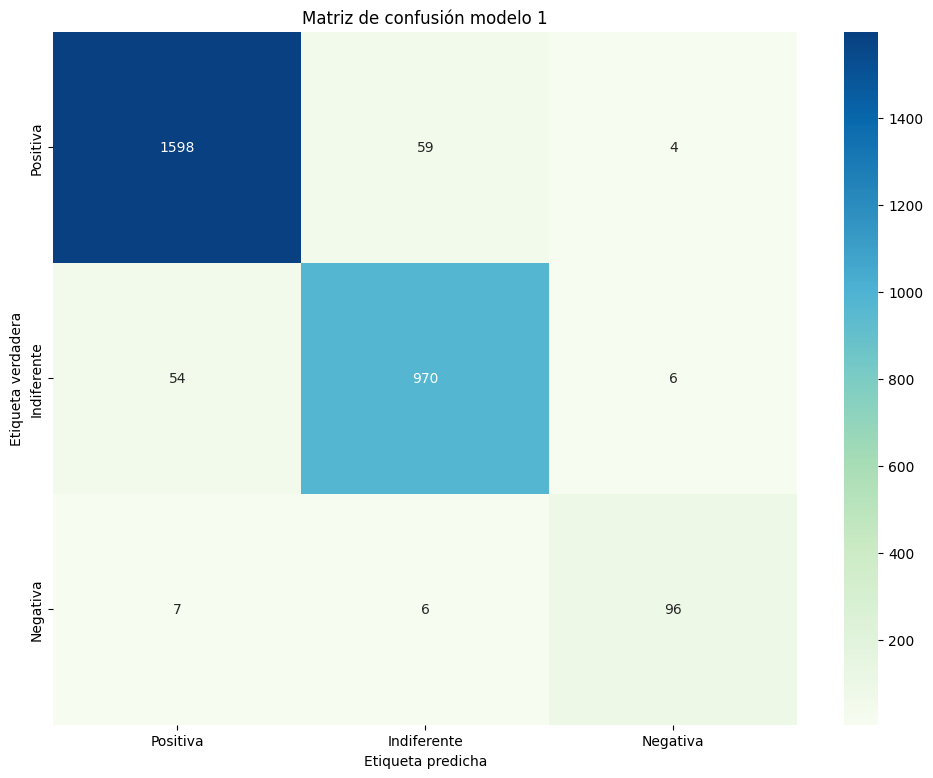

In [166]:
def plot_confusion_matrix(cm, classes, model_number):
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
    plt.title(f'Matriz de confusión modelo {model_number}')
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
    plt.show()

# Diccionario de clases
dict_clases = {0: 'Positiva', 1: 'Indiferente', 2: 'Negativa'}

# Lista de modelos
modelos = [model8]

# Iterar sobre los modelos
for i, modelo in enumerate(modelos):
    
    print(f'Generando matriz de confusión para el modelo {i+1}...')
    
    # Generar la matriz de confusión
    cm = confusion_matrix(modelo, test_loader)
    
    # Obtener las etiquetas de las clases en el orden correcto
    classes = [dict_clases[i] for i in range(len(dict_clases))]
    
    # Graficar la matriz de confusión
    plot_confusion_matrix(cm, classes, i+1)


In [119]:
from sklearn.metrics import f1_score

# Función para calcular las predicciones del modelo
def get_predictions(model, loader):
    model.eval()
    model = model.to(device=device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, preds = scores.max(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yi.cpu().numpy())
    return all_labels, all_preds

# Lista de modelos
modelos = [model7, model8]

# Iterar sobre los modelos
for i, modelo in enumerate(modelos):
    # Imprimir un mensaje para indicar en qué modelo va el conteo
    print(f'Calculando F1-score para el modelo {i+4}...')
    
    # Obtener las etiquetas verdaderas y las predicciones del modelo
    labels, preds = get_predictions(modelo, test_loader)
    
    # Calcular el F1-score
    f1 = f1_score(labels, preds, average='weighted')
    
    # Imprimir el F1-score
    print(f'F1-score para el modelo {i+4}: {f1:.2f}')


Calculando F1-score para el modelo 4...
F1-score para el modelo 4: 0.69
Calculando F1-score para el modelo 5...
F1-score para el modelo 5: 0.96


In [160]:
model_path = 'C:/Users/Usuario/Desktop/model8.pth'

In [161]:
torch.save(
    model8.state_dict(),
    model_path)

In [165]:
model8.state_dict()

OrderedDict([('0.0.0.0.weight',
              tensor([[[[ 5.0752e-02,  9.1917e-02,  1.3387e-01],
                        [ 2.7095e-01,  5.7192e-02,  7.5013e-02],
                        [ 1.6372e-01, -1.1249e-03,  5.8015e-02]],
              
                       [[ 1.6954e-01, -2.3987e-01, -1.6392e-01],
                        [ 4.6358e-02, -9.4348e-01, -8.7963e-01],
                        [ 1.0259e-01, -8.0457e-01, -7.5565e-01]],
              
                       [[ 3.8757e-02,  1.4110e-01,  1.4386e-01],
                        [ 3.0201e-01,  8.9284e-02,  4.3372e-02],
                        [ 1.8302e-01, -5.4797e-02, -8.7404e-02]]],
              
              
                      [[[ 1.1582e-02,  1.4667e-02,  1.0954e-02],
                        [ 1.1122e-03,  1.2503e-03, -7.9403e-04],
                        [-1.2201e-02, -1.2936e-02, -1.3367e-02]],
              
                       [[ 1.0848e-02,  1.5171e-02,  1.0659e-02],
                        [ 9.5882e-04,  2.66

In [164]:
model8

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, m